### Arrest Data Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics.cluster import adjusted_rand_score

In [124]:
arrests_df = pd.read_csv('arrests_data.csv')

arrests_df.head(2)

,Unnamed: 0,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5


In [125]:
# Let's give the state column an appropriate name

arrests_df.rename(columns={'Unnamed: 0': 'State'}, inplace=True)
arrests_df.head(2)

,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5


In [126]:
arrests_df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


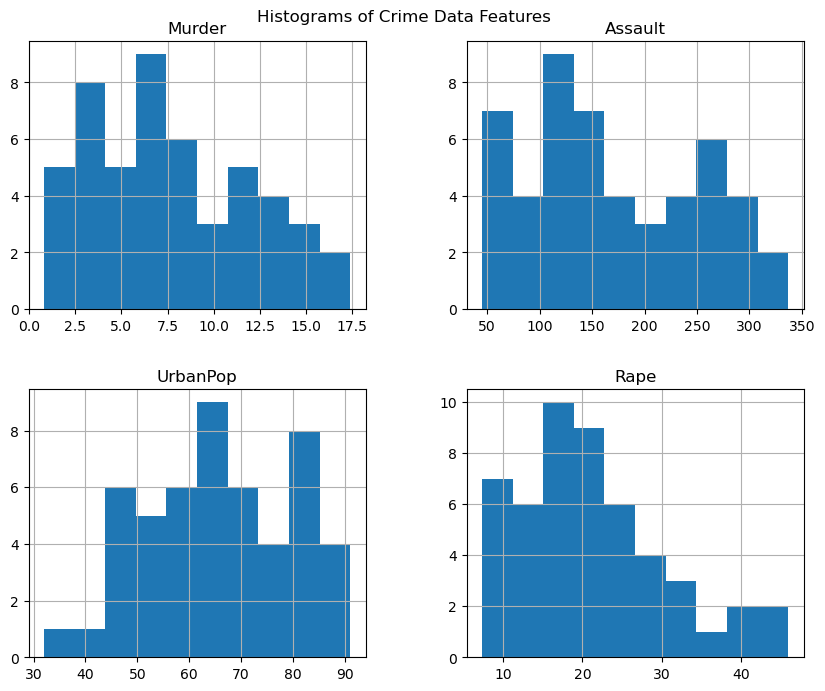

In [127]:
# Create histograms for each feature
features = ['Murder', 'Assault', 'UrbanPop', 'Rape']

arrests_df[features].hist(figsize=(10, 8)) 
plt.suptitle('Histograms of Crime Data Features', y=0.92)
plt.show()

#### EDA Commentary

There are no missing values, obvious outliers, negative/impossible values. Data is present for all 50 states.

 - UrbanPop likely represents the percentage of the state's population living in "urban" areas, as defined by US Census. This is a much broader definition than just "big cities".
 - Crime statistics are likely all on a "per 100,000 residents" scale. If on an absolute scale, we would expect much larger states like California to have much higher values.
 - Assault is more common than rape/sexual assault, which is more common than murder. This suggests these are all on the same scale.

In [128]:
scaler = StandardScaler()
numerical_features = arrests_df.columns[1:]
scaled_features = scaler.fit_transform(arrests_df[numerical_features])

In [129]:
correlation_matrix = arrests_df[['Murder', 'Assault', 'UrbanPop', 'Rape']].corr()
correlation_matrix

,Murder,Assault,UrbanPop,Rape
Murder,1.000000,0.801873,0.069573,0.563579
Assault,0.801873,1.000000,0.258872,0.665241
UrbanPop,0.069573,0.258872,1.000000,0.411341
Rape,0.563579,0.665241,0.411341,1.000000


#### Feature Selection/PCA

We've been instructed to select only three features for clustering. This seems like an odd choice as we're only starting with 4 features. However, the feature with the highest correlation is Assault, so this is the one we would drop.

We're next asked to use PCA to reduce to 2 principal components. It seems to make more sense to apply this PCA to the original 4, as PCA is inherently "throwing away" some information anyway.

In [130]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=arrests_df.index)

print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")
print(f"Total Variance Explained (2 components): {sum(pca.explained_variance_ratio_):.2f}")

Explained Variance Ratio: [0.62006039 0.24744129]
Total Variance Explained (2 components): 0.87


#### KMeans Clustering

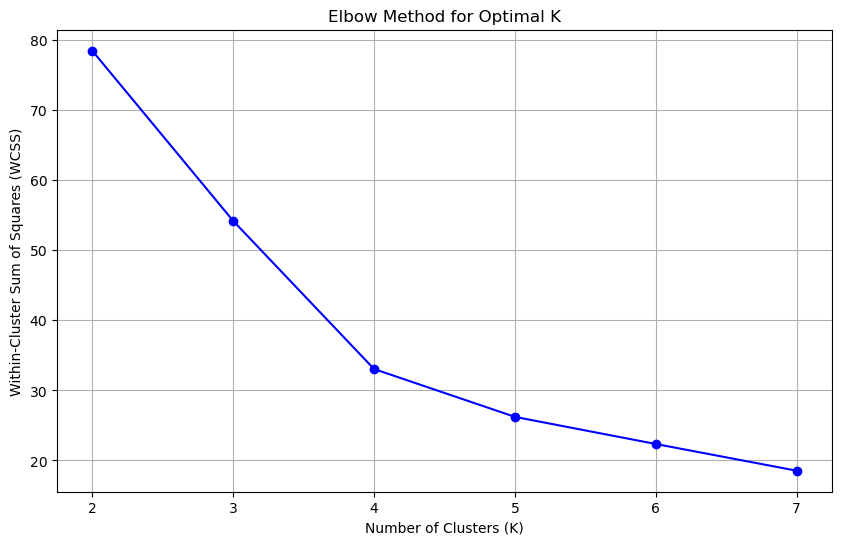

In [131]:
k_values = range(2, 8)

wcss = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(principal_components)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, 'bo-') 
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

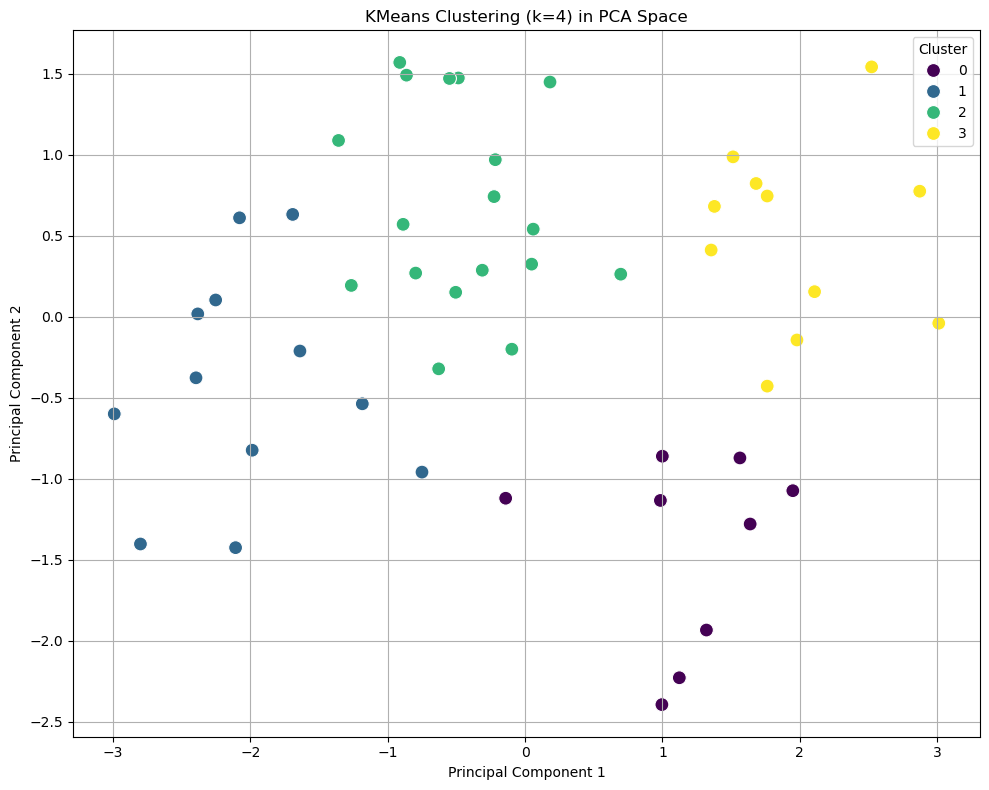

In [155]:
optimal_k_kmeans = 4
kmeans = KMeans(n_clusters=optimal_k_kmeans, random_state=42, n_init=10)
pca_df['KMeans_Cluster'] = kmeans.fit_predict(principal_components)

def plot_in_pca_space(title, hue):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PC1', y='PC2', hue=hue, data=pca_df, palette='viridis', s=100)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'{title} in PCA Space')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
plot_in_pca_space('KMeans Clustering (k=4)', 'KMeans_Cluster')

In [133]:
pca_df.head()

,PC1,PC2,KMeans_Cluster
0,0.985566,-1.133392,0
1,1.950138,-1.073213,0
2,1.763164,0.745957,3
3,-0.141420,-1.119797,0
4,2.523980,1.542934,3


In [134]:
crime_data_with_clusters = pd.merge(arrests_df, pca_df['KMeans_Cluster'], left_index=True, right_index=True)
# Print the cluster means
cluster_means = pca_df.groupby('KMeans_Cluster')[['PC1', 'PC2']].mean()
print("Cluster Means (on Principal Components):")
cluster_means

Cluster Means (on Principal Components):


,PC1,PC2
KMeans_Cluster,,
0,1.159858,-1.432428
1,-2.022741,-0.413884
2,-0.451302,0.685736
3,1.996146,0.501383


In [135]:
crime_data_with_clusters.head(3)

,State,Murder,Assault,UrbanPop,Rape,KMeans_Cluster
0,Alabama,13.2,236,58,21.2,0
1,Alaska,10.0,263,48,44.5,0
2,Arizona,8.1,294,80,31.0,3


In [136]:
print("States in Each Cluster:")
for cluster_num in sorted(crime_data_with_clusters['KMeans_Cluster'].unique()):
    states_in_cluster = crime_data_with_clusters[crime_data_with_clusters['KMeans_Cluster'] == cluster_num]['State'].tolist()
    print(f"Cluster {cluster_num}: {states_in_cluster}")

States in Each Cluster:
Cluster 0: ['Alabama', 'Alaska', 'Arkansas', 'Georgia', 'Louisiana', 'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee']
Cluster 1: ['Idaho', 'Iowa', 'Kentucky', 'Maine', 'Minnesota', 'Montana', 'New Hampshire', 'North Dakota', 'South Dakota', 'Vermont', 'West Virginia', 'Wisconsin']
Cluster 2: ['Connecticut', 'Delaware', 'Hawaii', 'Indiana', 'Kansas', 'Massachusetts', 'Missouri', 'Nebraska', 'New Jersey', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'Utah', 'Virginia', 'Washington', 'Wyoming']
Cluster 3: ['Arizona', 'California', 'Colorado', 'Florida', 'Illinois', 'Maryland', 'Michigan', 'Nevada', 'New Mexico', 'New York', 'Texas']



#### Cluster Analysis

Some rough generalizations about the clusters assigned:

 - Cluster 0 - Southern states
 - Cluster 1 - generally smaller/less dense states with lower urban populations, generally midwest region
 - Cluster 2 - smaller states except Pennsylvania, Virginia, New Jersey (largest group)
 - Cluster 3 - larger states


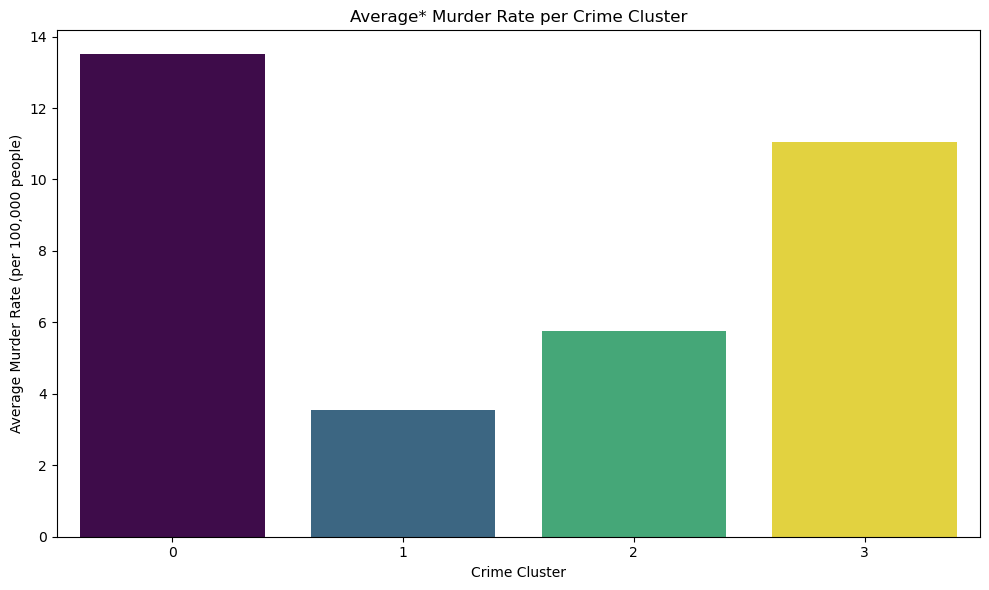


Average Murder Rate per Cluster (Original Scale):
KMeans_Cluster
0    13.500000
3    11.054545
2     5.766667
1     3.541667
Name: Murder, dtype: float64


In [160]:
# Calculate the average murder rate for each cluster using the original 'Murder' column
average_murder_per_cluster = crime_data_with_clusters.groupby('KMeans_Cluster')['Murder'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=average_murder_per_cluster.index, y=average_murder_per_cluster.values, palette='viridis', hue=average_murder_per_cluster.index, legend=False)
plt.title('Average* Murder Rate per Crime Cluster')
plt.xlabel('Crime Cluster')
plt.ylabel('Average Murder Rate (per 100,000 people)')
plt.tight_layout()
plt.show()

print("\nAverage Murder Rate per Cluster (Original Scale):")
print(average_murder_per_cluster)

##### 'Average' Note

The 'average' murder rate above is not a true average. If we were looking at the actual average murder rate for an entire cluster, we would have to use absolute numbers to weigh larger states appropriately. In the calculations above, California counts just as much towards its groups 'average' as does Wyoming.

This is just a visualization to examine the clusters.

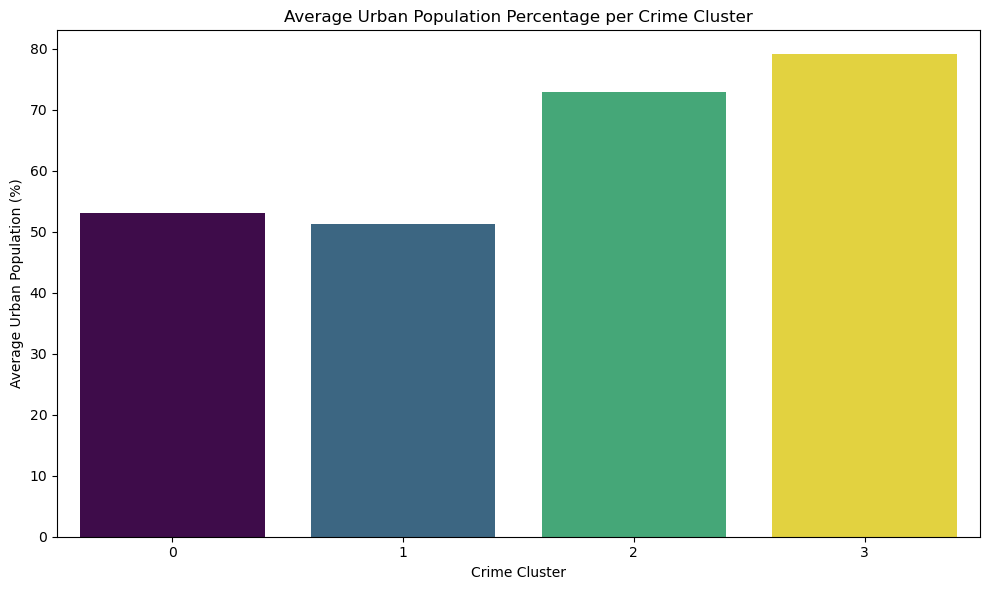

In [138]:
average_urban_pop_per_cluster = crime_data_with_clusters.groupby('KMeans_Cluster')['UrbanPop'].mean().sort_values(ascending=False)

# Create the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=average_urban_pop_per_cluster.index, y=average_urban_pop_per_cluster.values,
             palette='viridis', hue=average_urban_pop_per_cluster.index, legend=False)
plt.title('Average Urban Population Percentage per Crime Cluster')
plt.xlabel('Crime Cluster')
plt.ylabel('Average Urban Population (%)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### GMM Clustering

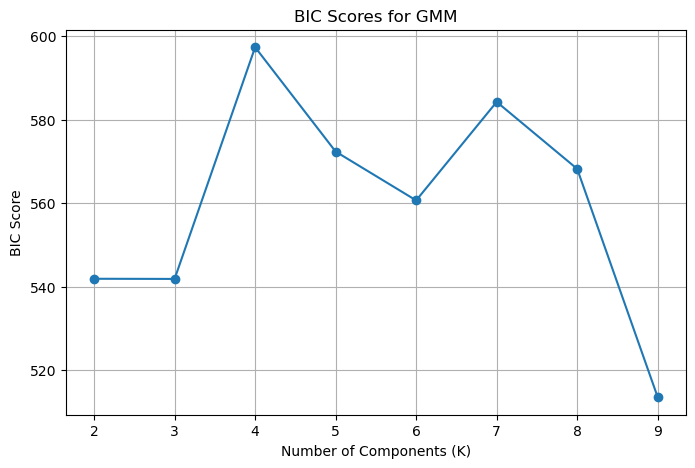

In [139]:
# Bayesian
bic_scores = []
k_values = range(2, 10)

# for loop
for k in k_values:
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
    gmm.fit(scaled_features)
    bic_scores.append(gmm.bic(scaled_features))

plt.figure(figsize=(8, 5))
plt.plot(k_values, bic_scores, marker='o', linestyle='-')
plt.xlabel("Number of Components (K)")
plt.ylabel("BIC Score")
plt.title("BIC Scores for GMM")
plt.grid(True)
plt.show()

#### BIC Score and K Choice

(Keep in mind the scale of the Y axis above - the changes in scores are not as large as they appear)

While k=4 seemed like an optimal value for KMeans based on the elbow method, k=4 is actually the highest BIC score for GMM, highlighting the difference in the techniques. There are reasonable cases to be made here for 2, 3, 4, 6, and 9. Given that k=9 would be a substantially more complicated model, and the BIC score change is not especially large (541 vs 513), we will use k=3. 

In [152]:
optimal_k_gmm = 3
gmm = GaussianMixture(n_components=optimal_k_gmm, random_state=42, n_init=10)
gmm.fit(scaled_features)
gmm_clusters = gmm.predict(scaled_features)
pca_df['GMM_Cluster'] = gmm_clusters

In [141]:
pca_df.head()

,PC1,PC2,KMeans_Cluster,GMM_Cluster
0,0.985566,-1.133392,0,0
1,1.950138,-1.073213,0,0
2,1.763164,0.745957,3,3
3,-0.141420,-1.119797,0,0
4,2.523980,1.542934,3,3


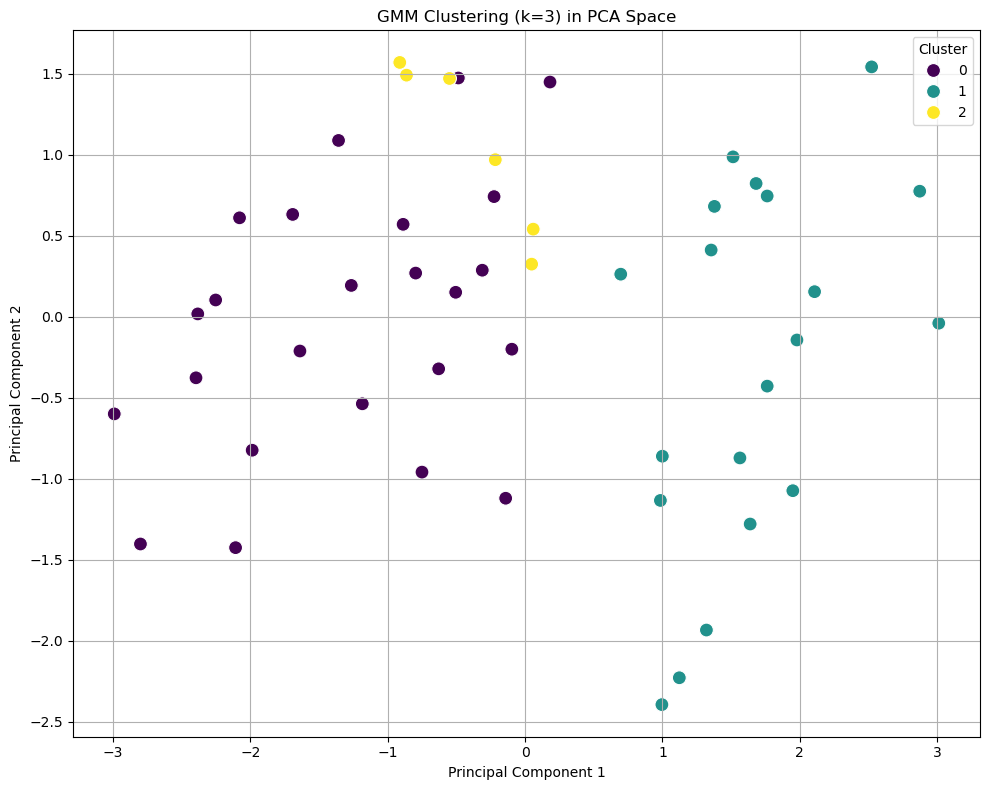

In [ ]:
plot_in_pca_space('GMM Clustering (k=3)', 'GMM_Cluster')

#### GMM With K=4

It is difficult to compare these with different K-values. Let's examine GMM with k=4.

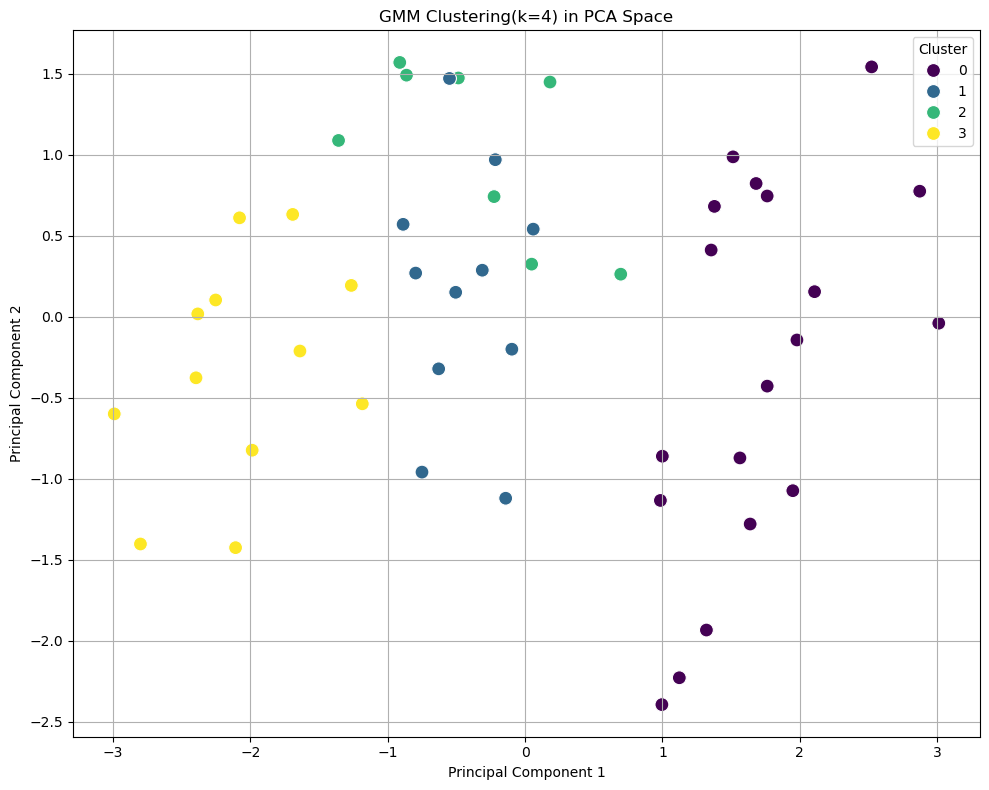

In [ ]:
gmm = GaussianMixture(n_components=4, random_state=42, n_init=10)
gmm.fit(scaled_features)
gmm_clusters = gmm.predict(scaled_features)
pca_df['GMM_Cluster_k4'] = gmm_clusters
cluster_proba_k4 = gmm.predict_proba(scaled_features)

plot_in_pca_space('GMM Clustering(k=4)', 'GMM_Cluster_k4')

In [ ]:
# Use ARI to compare the results - how many state pairs are in the same groups with both models

kmeans_labels = pca_df['KMeans_Cluster']
gmm_labels = pca_df['GMM_Cluster_k4']

ari_score = adjusted_rand_score(kmeans_labels, gmm_labels)
print(f"Adjusted Rand Index between KMeans and GMM (k=4): {ari_score:.3f}")

Adjusted Rand Index between KMeans and GMM (k=4): 0.517


### Conclusion

KMeans modeling produced more visually distinct clusters in our 2D PCA space, as expected. If explainability is a primary factor, KMeans is the best option.

#### Further Steps

There are many ways we could take this analysis further:

 - Try GMM with k=9 and compare the results with KMeans. Is GMM with higher K identifying subgroups 
 - Use a combination of KMeans and GMM to identify state pairs/groups that are similar with a high degree of confidence
 - Explore KMeans and GMM clustering without PCA
 - Bring subject matter experts (demographers, crime analysts) in to evaluate the utility of different models
 - Explore GMM confidence values